# (WIP) Exporting Replicated Instance Data for Analytics

This project documents and end-to-end workflow for querying timeseries event data and producing
a number of charts and visualizations for various instance characteristics.

As of 2023-10-23, it is a work in progress.

In [200]:
import json

with open("config.json") as configfile:
    config = json.load(configfile)

REPLICATED_API_TOKEN = config["REPLICATED_API_TOKEN"]
REPLICATED_APP_ID = config["REPLICATED_APP_ID"]

import logging

logging.basicConfig(
    format='%(asctime)s %(levelname)-8s %(message)s',
    level=logging.INFO,
    datefmt='%Y-%m-%d %H:%M:%S'
)

### Fetching an instance

In [39]:
import requests

resp = requests.get(
    f"https://api.replicated.com/vendor/v3/app/{REPLICATED_APP_ID}/customer_instances?format=json",
    headers=dict(Authorization=REPLICATED_API_TOKEN),
)

customers = resp.json()

instance = customers[0]["instances"][1]

instance





2023-10-26 16:08:02 DEBUG    Starting new HTTPS connection (1): api.replicated.com:443
2023-10-26 16:08:03 DEBUG    https://api.replicated.com:443 "GET /vendor/v3/app/2C0OQyxiiA4pc3blK0cKs5VQS3N/customer_instances?format=json HTTP/1.1" 200 None


{'instanceId': '143421a2-38cf-4cfb-93cc-6f48d0e23bd0',
 'isActive': True,
 'firstReportedAt': '2023-09-15T21:20:47.07Z',
 'lastReportedAt': '2023-10-26T12:35:00.946Z',
 'firstReadyAt': '2023-09-15T21:22:08.461Z',
 'kotsVersion': '1.0.0-beta.8',
 'k8sVersion': 'v1.26.6-gke.1700',
 'isAirgap': False,
 'isKurl': False,
 'lastAppStatus': 'ready',
 'client': 'Replicated-SDK',
 'kurlNodeCountTotal': 0,
 'kurlNodeCountReady': 0,
 'cloudProvider': 'gcp',
 'cloudProviderRegion': 'us-central1',
 'versionLabel': '2.1.0',
 'versionAge': 0,
 'isGitOpsEnabled': False,
 'gitopsProvider': '',
 'isSkipPreflights': None,
 'preflightStatus': None,
 'k8sDistribution': 'gke',
 'customMetricsReportedAt': '2023-10-04T20:50:38.213Z',
 'customMetricsData': {'activeUsers': 8,
  'projectCount': 16,
  'usingCustomRoles': False,
  'usingCustomThemes': True}}

### Fetching all instance events

In [218]:
start_date = '2023-01-01'
event_types= 'k8sVersion'

resp = requests.get(
    f"https://api.replicated.com/vendor/v3/app/{REPLICATED_APP_ID}/events?after={start_date}&eventTypes={event_types}",
    headers=dict(Authorization=REPLICATED_API_TOKEN),
)

events = resp.json()

eventsByTime = sorted(events, key=lambda event: event['reportedAt'])

# preview earlist three events
print("Total events:", len(events), "\n\n", json.dumps(eventsByTime[:3], indent=2))

2023-10-27 11:11:06 DEBUG    Starting new HTTPS connection (1): api.replicated.com:443
2023-10-27 11:11:10 DEBUG    https://api.replicated.com:443 "GET /vendor/v3/app/2C0OQyxiiA4pc3blK0cKs5VQS3N/events?after=2023-01-01&eventTypes=k8sVersion HTTP/1.1" 200 None


Total events: 77 

 [
  {
    "customerId": "2JBxR7eNpTA5vl2rkkmUbVozdLd",
    "instanceId": "2Jrt68xMCzvFNVdXkpwTTVfynJ5",
    "appId": "2C0OQyxiiA4pc3blK0cKs5VQS3N",
    "reportedAt": "2023-01-04T16:01:18",
    "fieldName": "k8sVersion",
    "isCustom": false,
    "newValue": "v1.26.0",
    "previousValue": ""
  },
  {
    "customerId": "2JBxR7eNpTA5vl2rkkmUbVozdLd",
    "instanceId": "2JK93avStGaNpwTfiHHUkc2iZ9p",
    "appId": "2C0OQyxiiA4pc3blK0cKs5VQS3N",
    "reportedAt": "2023-01-04T17:03:01",
    "fieldName": "k8sVersion",
    "isCustom": false,
    "newValue": "v1.23.13-gke.900",
    "previousValue": "v1.23.12-gke.1600"
  },
  {
    "customerId": "2JBxR7eNpTA5vl2rkkmUbVozdLd",
    "instanceId": "2JK9CVvBanaQdrQgbn7F1KawST7",
    "appId": "2C0OQyxiiA4pc3blK0cKs5VQS3N",
    "reportedAt": "2023-01-04T17:07:02",
    "fieldName": "k8sVersion",
    "isCustom": false,
    "newValue": "v1.23.13-gke.900",
    "previousValue": "v1.23.12-gke.1600"
  }
]


# Organizing Events into timeseries

here's where thing get dicey - we want to take a stream of events looking like

In [219]:

eventsInput = [{
    'reportedAt': '2023-10-02T00:00:00.00',
    'newValue': '1.27.1-gke.1700',
    'instanceId': 'instance-1'
},
          {
    'reportedAt': '2023-10-01T00:00:00.00',
    'newValue': '1.27.0-gke.1700',
    'instanceId': 'instance-2'
}, {
    'reportedAt': '2023-10-05T00:00:00.00',
    'newValue': '1.28.0-gke.1700',
    'instanceId': 'instance-1',
}, {
    'reportedAt': '2023-10-06T00:00:00.00',
    'newValue': '1.28.0-gke.1700',
    'instanceId': 'instance-2',
},
]





We also need to know instance active intervals, so that we can pull instances from the "active instance counts" when they go inactive.

In [242]:
input_instances = [
   {
    'instanceId': 'instance-1',
    'firstReportedAt': '2023-10-02T00:00:00.00',
    'lastReportedAt': '2023-10-06T00:00:00.00',
},
       {
    'instanceId': 'instance-2',
    'firstReportedAt': '2023-10-01T00:00:00.00',
    'lastReportedAt': '2023-10-09T00:00:00.00', 
}]

We then want to  **turn these into** a table with **date* as the primary key, and a count for instances on each version as the columns

In [256]:

expected_output = [
    {
        'date': '2023-10-01',
        '1.27.0-gke.1700': 1,
        '1.27.1-gke.1700': 0,
        '1.28.0-gke.1700': 0,
    },
    {
        'date': '2023-10-02',
        '1.27.0-gke.1700': 1,
        '1.27.1-gke.1700': 1,
        '1.28.0-gke.1700': 0,

    },
    {
        'date': '2023-10-03',
        '1.27.0-gke.1700': 1,
        '1.27.1-gke.1700': 1,
        '1.28.0-gke.1700': 0,

    },
    {
        'date': '2023-10-04',
        '1.27.0-gke.1700': 1,
        '1.27.1-gke.1700': 1,
        '1.28.0-gke.1700': 0,

    },
    {
        'date': '2023-10-05',
        '1.27.0-gke.1700': 1,
        '1.27.1-gke.1700': 0,
        '1.28.0-gke.1700': 1,
    },
    {
        'date': '2023-10-06',
        '1.27.0-gke.1700': 0,
        '1.27.1-gke.1700': 0,
        '1.28.0-gke.1700': 2,
    },
    {
        'date': '2023-10-07',
        '1.27.0-gke.1700': 0,
        '1.27.1-gke.1700': 0,
        '1.28.0-gke.1700': 1,
    },
    {
        'date': '2023-10-08',
        '1.27.0-gke.1700': 0,
        '1.27.1-gke.1700': 0,
        '1.28.0-gke.1700': 1,
    },
    {
        'date': '2023-10-09',
        '1.27.0-gke.1700': 0,
        '1.27.1-gke.1700': 0,
        '1.28.0-gke.1700': 1,
    },
]

pd.DataFrame.from_records(expected_output)

,date,1.27.0-gke.1700,1.27.1-gke.1700,1.28.0-gke.1700
0,2023-10-01,1,0,0
1,2023-10-02,1,1,0
2,2023-10-03,1,1,0
3,2023-10-04,1,1,0
4,2023-10-05,1,0,1
5,2023-10-06,0,0,2
6,2023-10-07,0,0,1
7,2023-10-08,0,0,1
8,2023-10-09,0,0,1


The function below does that, but we wont go into too much detail on how it works here

In [298]:
import pandas as pd
from datetime import datetime
import itertools
from collections import defaultdict




def parseInstanceEventDate(event):
    """
    janky time parsing. If neither of these work we'll get an exception 👍
    """
    try: 
        return datetime.strptime(event['reportedAt'], '%Y-%m-%dT%H:%M:%S.%f')
    except:
            return datetime.strptime(event['reportedAt'], '%Y-%m-%dT%H:%M:%S')


            
# convert a pile of events into a timeseries object
def events_to_timeseries(inputEvents, instances, start, days):
    """
    date-spine raw events
    """
    datelist = pd.date_range(start, periods=days).tolist()
    events_by_date = {k: list(v) for k, v in itertools.groupby(inputEvents, lambda event: parseInstanceEventDate(event).strftime("%Y-%m-%d"))}
    instances_by_id = {instance['instanceId']: instance for instance in instances}
    instance_states = {}
    daily_records = []
    all_versions_seen = set()
    instances_not_found = set()

    for date in datelist:
        instances_per_state = defaultdict(int)
        string_date = date.strftime('%Y-%m-%d')
        
        events = events_by_date.get(string_date, [])
        # sort events so we're always using the latest status on a given day
        events = sorted(events, key=lambda event: event['reportedAt'])
        
        # remove instances that are no longer active
        instances_to_remove = []
        for instance_id,state in instance_states.items():
            instance = instances_by_id.get(instance_id)
            if not instance:
                instances_not_found.add(instance_id)
                instances_to_remove.append(instance_id)
                continue
            instance_last_active = instance.get('lastReportedAt')
            if not instance_last_active:
                logging.debug('instance %s had no last reported at', instance_id)
                continue
            if instance_last_active < string_date:
                instances_to_remove.append(instance_id)

        for instance_id in instances_to_remove:
            # logging.debug('will remove instance %s on %s because its last reported is %s', instance_id, string_date, instance_last_active)
            del instance_states[instance_id]
        
        for event in events:
            instance_states[event['instanceId']] = event['newValue']
            all_versions_seen.add(event['newValue'])
        for instanceId, state in instance_states.items():
            instances_per_state[state] += 1
        # logging.debug("%s %s %s", date, instance_states, instances_per_state)

        record = {
            'date': date.strftime('%Y-%m-%d'),
        }
        record.update(instances_per_state)
        daily_records.append(record)

    # normalize to add zeroes where columns may be missing
    for record in daily_records:
        for version in all_versions_seen:
            record[version] = record.get(version, 0)
    if len(instances_not_found) > 0:
        # logging.debug('could not find %s instances %s', len(instances_not_found), instances_not_found)
        pass

    return daily_records



result = events_to_timeseries(eventsInput, input_instances, datetime(2023,10,1), 9)

print(json.dumps(result[4:], indent=1))

from unittest import TestCase
TestCase().assertEqual(result, expected_output)


[
 {
  "date": "2023-10-05",
  "1.27.0-gke.1700": 1,
  "1.28.0-gke.1700": 1,
  "1.27.1-gke.1700": 0
 },
 {
  "date": "2023-10-06",
  "1.28.0-gke.1700": 2,
  "1.27.1-gke.1700": 0,
  "1.27.0-gke.1700": 0
 },
 {
  "date": "2023-10-07",
  "1.28.0-gke.1700": 1,
  "1.27.1-gke.1700": 0,
  "1.27.0-gke.1700": 0
 },
 {
  "date": "2023-10-08",
  "1.28.0-gke.1700": 1,
  "1.27.1-gke.1700": 0,
  "1.27.0-gke.1700": 0
 },
 {
  "date": "2023-10-09",
  "1.28.0-gke.1700": 1,
  "1.27.1-gke.1700": 0,
  "1.27.0-gke.1700": 0
 }
]


In [279]:
resp = requests.get(
    f"https://api.replicated.com/vendor/v3/app/{REPLICATED_APP_ID}/customer_instances?format=json",
    headers=dict(Authorization=REPLICATED_API_TOKEN),
)

all_instances = [instance for instance in customer['instances'] for customer in resp.json()]

len(all_instances)

2023-10-27 11:55:57 DEBUG    Starting new HTTPS connection (1): api.replicated.com:443
2023-10-27 11:55:58 DEBUG    https://api.replicated.com:443 "GET /vendor/v3/app/2C0OQyxiiA4pc3blK0cKs5VQS3N/customer_instances?format=json HTTP/1.1" 200 None


76

In [278]:
start_date = '2023-01-01'
event_types= 'k8sVersion'

resp = requests.get(
    f"https://api.replicated.com/vendor/v3/app/{REPLICATED_APP_ID}/events?after={start_date}&eventTypes={event_types}",
    headers=dict(Authorization=REPLICATED_API_TOKEN),
)

k8sVersionEvents = resp.json()

k8sVersionEvents = sorted(events, key=lambda event: event['reportedAt'])


2023-10-27 11:55:53 DEBUG    Starting new HTTPS connection (1): api.replicated.com:443
2023-10-27 11:55:57 DEBUG    https://api.replicated.com:443 "GET /vendor/v3/app/2C0OQyxiiA4pc3blK0cKs5VQS3N/events?after=2023-01-01&eventTypes=k8sVersion HTTP/1.1" 200 None


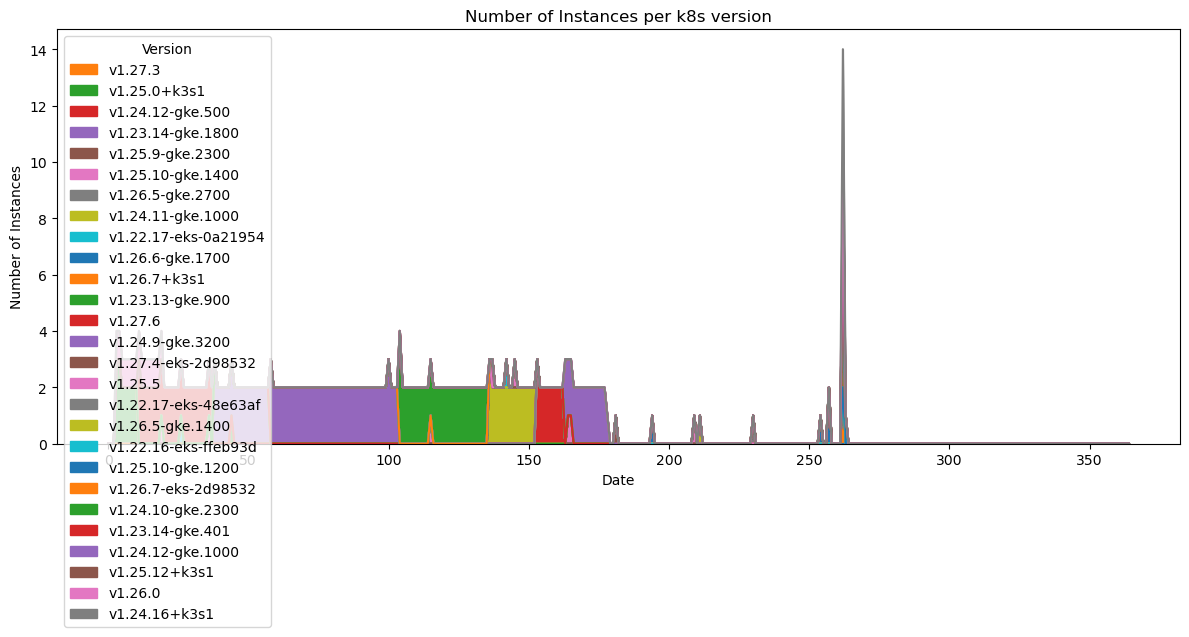

In [299]:

timeseries = events_to_timeseries(eventsByTime, all_instances, datetime(2023,1,1), 365)
df = pd.DataFrame.from_records(timeseries)


import matplotlib.pyplot as plt

df.set_index('date')
df.plot(kind='area', stacked=True, figsize=(12, 6))
plt.title('Number of Instances per k8s version')
plt.ylabel('Number of Instances')
plt.xlabel('Date')
plt.legend(title='Version', loc='upper left')
plt.tight_layout()
plt.show()

In [270]:
start_date = '2023-01-01'
event_types= 'versionLabel'

resp = requests.get(
    f"https://api.replicated.com/vendor/v3/app/{REPLICATED_APP_ID}/events?after={start_date}&eventTypes={event_types}",
    headers=dict(Authorization=REPLICATED_API_TOKEN),
)


versionEvents = sorted(resp.json(), key=lambda event: event['reportedAt'])


2023-10-27 11:44:00 DEBUG    Starting new HTTPS connection (1): api.replicated.com:443
2023-10-27 11:44:04 DEBUG    https://api.replicated.com:443 "GET /vendor/v3/app/2C0OQyxiiA4pc3blK0cKs5VQS3N/events?after=2023-01-01&eventTypes=versionLabel HTTP/1.1" 200 None


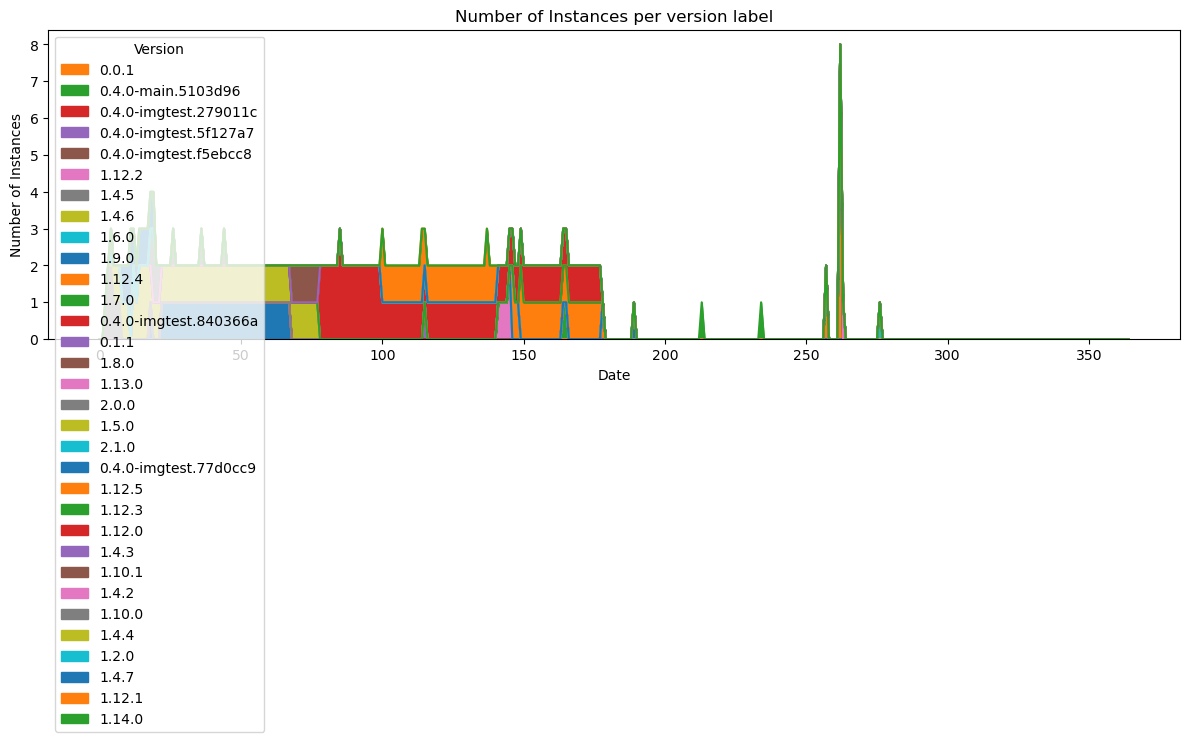

In [300]:

timeseries = events_to_timeseries(versionEvents, all_instances, datetime(2023,1,1), 365)
df = pd.DataFrame.from_records(timeseries)


import matplotlib.pyplot as plt

df.plot(kind='area', stacked=True, figsize=(12, 6))
plt.title('Number of Instances per version label')
plt.ylabel('Number of Instances')
plt.xlabel('Date')
plt.legend(title='Version', loc='upper left')
plt.tight_layout()
plt.show()